In [50]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import geopandas as gpd

In [2]:
from scipy.spatial.distance import cdist, pdist
import scipy.cluster.hierarchy as shc
import matplotlib.cm as cm
import os

In [3]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

## Load Data Sets
Downloaded from Equitable Development Data Explorer GitHub repository: https://github.com/NYCPlanning/db-equitable-development-tool/tree/main/resources

In [5]:
path = '../data/'
job_access_path = 'access_to_jobs.csv'
housing_path = 'EDDT_ACS2015-2019.xlsx'
race_dec_path = 'EDDT_Census00-10-20_MUTU.xlsx'
demog_19_path = 'EDDT_Dem_ACS2015-2019.xlsx'
hh_econ_path = 'EDDT_HHEconSec_ACS2015-2019.xlsx'
units_aff_path = 'EDDT_UnitsAffordablebyAMI_2015-2019.xlsx'
dri_path = 'Equitable.Development.Data.Tool.-.Displacement.Risk.Index.2-8-2022.1.xlsx'
park_access_path = 'Park_Access.xlsx'

In [6]:
boro_names = ['NYC','Bronx','Brooklyn','Manhattan','Queens','Staten Island']

In [7]:
park_access = pd.read_excel(f'{path}{park_access_path}')
park_access = park_access.loc[~park_access['PUMA'].isin(boro_names)]
park_access.rename(columns={'Perc':'park_perc','PUMA':'PUMA_short'},inplace=True)
park_access['PUMA'] = '360'+park_access['PUMA_short'].astype(str)
park_access.head()

,PUMA_short,Pop_Served,Total_Pop20,park_perc,PUMA
0,3701,104085,113700,91.543536,3603701
1,3702,94287,148709,63.403694,3603702
2,3703,61828,123837,49.926920,3603703
3,3704,110207,130351,84.546340,3603704
4,3705,176653,178035,99.223748,3603705


In [8]:
hh_econ = pd.read_excel(f'{path}{hh_econ_path}')
hh_econ = hh_econ.loc[~hh_econ['Geog'].isin(boro_names)]
hh_econ['PUMA'] = '360'+hh_econ['Geog'].astype(str)
hh_econ.head()

,Geog,P25p_19E,P25p_19M,P25p_19C,P25p_19P,P25p_19Z,LtHS_19E,LtHS_19M,LtHS_19C,LtHS_19P,...,MWoth_A19M,MWoth_A19C,MWoth_A19P,MWoth_A19Z,MWpbadm_A19E,MWpbadm_A19M,MWpbadm_A19C,MWpbadm_A19P,MWpbadm_A19Z,PUMA
6,3701,77539,1586,1.2,100,NaN,14093,1163,5.0,18.2,...,NaN,NaN,NaN,NaN,139284.0,162682.0,71.0,NaN,NaN,3603701
7,3702,101302,1996,1.2,100,NaN,19953,1337,4.1,19.7,...,NaN,NaN,NaN,NaN,13735.0,37476.0,165.9,NaN,NaN,3603702
8,3703,87544,2326,1.6,100,NaN,14779,1623,6.7,16.9,...,120584.0,473.0,NaN,NaN,22498.0,19396.0,52.4,NaN,NaN,3603703
9,3704,88338,1839,1.3,100,NaN,19059,1212,3.9,21.6,...,5042.0,19.7,NaN,NaN,80657.0,29300.0,22.1,NaN,NaN,3603704
10,3705,101379,2083,1.2,100,NaN,34831,1725,3.0,34.4,...,34808.0,111.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3603705


In [9]:
job_access = pd.read_csv(f'{path}{job_access_path}')
job_access['PUMA'] = job_access['PUMA'].astype(str)
job_access = job_access.loc[~job_access['PUMA'].isin(boro_names)]
job_access = pd.merge(job_access,hh_econ[['PUMA','LF_19E']],how='left',on='PUMA')
job_access['job_perc'] = (job_access[
    'Weighted Average Number of Jobs Accessible within 30 mins from Tract Centroid by Transit']*100)/job_access['LF_19E']
job_access.head()

,PUMA,Weighted Average Number of Jobs Accessible within 30 mins from Tract Centroid by Transit,LF_19E,job_perc
0,3603701,45439,50545,89.898111
1,3603702,33763,72051,46.859863
2,3603703,20265,55725,36.366083
3,3603704,53255,60205,88.456108
4,3603705,81569,70950,114.966878


In [10]:
job_access['job_perc_norm'] = (job_access['job_perc']-job_access['job_perc'].min())*100/(job_access['job_perc'].max()-job_access['job_perc'].min())
job_access.job_perc_norm.describe()

count     55.000000
mean      14.914076
std       23.019639
min        0.000000
25%        3.276029
50%        6.759761
75%       11.301514
max      100.000000
Name: job_perc_norm, dtype: float64

In [11]:
housing = pd.read_excel(f'{path}{housing_path}')
housing = housing.loc[~housing['Geog'].isin(boro_names)]
housing['PUMA'] = '360'+housing['Geog'].astype(str)
housing.head()

,Geog,OcHU1_19E,OcHU1_19M,OcHU1_19C,OcHU1_19P,OcHU1_19Z,OOcc1_19E,OOcc1_19M,OOcc1_19C,OOcc1_19P,...,Comp_A19M,Comp_A19C,Comp_A19P,Comp_A19Z,BbInt_A19E,BbInt_A19M,BbInt_A19C,BbInt_A19P,BbInt_A19Z,PUMA
6,3701,42884,645,0.9,100,NaN,13347,817,3.7,31.1,...,256,10.7,92.9,5.1,1289,236,11.1,82.5,6.0,3603701
7,3702,50543,607,0.7,100,NaN,19234,945,3.0,38.1,...,278,17.9,79.2,16.0,885,240,16.5,74.4,12.2,3603702
8,3703,47805,548,0.7,100,NaN,22513,1265,3.4,47.1,...,278,17.2,75.8,6.9,869,275,19.3,67.1,11.4,3603703
9,3704,44700,549,0.7,100,NaN,13295,810,3.7,29.7,...,340,7.1,90.8,2.3,2389,322,8.2,74.0,5.4,3603704
10,3705,58786,548,0.6,100,NaN,3846,494,7.8,6.5,...,184,34.5,57.4,23.2,310,177,34.6,55.0,22.4,3603705


In [12]:
units_aff = pd.read_excel(f'{path}{units_aff_path}')
units_aff = units_aff.loc[~units_aff['Geog'].isin(boro_names)]
units_aff['PUMA'] = '360'+units_aff['Geog'].astype(str)
units_aff.head()

,Geog,ROcc2_19E,ROcc2_19M,ROcc2_19C,ROcc2_19P,ROcc2_19Z,AfELI_19E,AfELI_19M,AfELI_19C,AfELI_19P,...,AfMidi_19M,AfMidi_19C,AfMidi_19P,AfMidi_19Z,AfHI_19E,AfHI_19M,AfHI_19C,AfHI_19P,AfHI_19Z,PUMA
6,3701,29081,879,1.8,100,NaN,2708,491,11.0,9.3,...,259,15.6,3.5,0.9,159,130.0,49.7,0.5,0.4,3603701
7,3702,30469,1106,2.2,100,NaN,4125,565,8.3,13.5,...,35,77.7,0.1,0.1,12,19.0,98.7,0.0,0.1,3603702
8,3703,24935,1291,3.1,100,NaN,3578,780,13.2,14.3,...,117,47.6,0.6,0.5,33,61.0,111.5,0.1,0.2,3603703
9,3704,30768,959,1.9,100,NaN,3388,447,8.0,11.0,...,118,35.8,0.7,0.4,14,18.0,78.1,0.0,0.1,3603704
10,3705,53565,846,1.0,100,NaN,14696,1130,4.7,27.4,...,61,44.0,0.2,0.1,0,NaN,NaN,NaN,NaN,3603705


In [13]:
race_dec = pd.read_excel(f'{path}{race_dec_path}')
race_dec = race_dec.loc[~race_dec['GeogType'].isin(boro_names)]
race_dec['PUMA'] = ('360'+race_dec['GeoID'].astype(int).astype(str))
race_dec.head()

,GeogType,GeoID,Pop20,Pop20P,Hsp20,Hsp20P,WNH20,WNH20P,BNH20,BNH20P,...,Hsp00P,WNH00,WNH00P,BNH00,BNH00P,ANH00,ANH00P,OTwoNH00,OTwoNH00P,PUMA
6,PUMA2010,3701.0,113700,100,56187,49.4,34285,30.2,13297,11.7,...,37.4,45378,41.8,14075,13.0,5556,5.1,2960,2.7,3603701
7,PUMA2010,3702.0,148709,100,39442,26.5,8930,6.0,90173,60.6,...,17.5,13783,10.1,90648,66.4,2579,1.9,5474,4.0,3603702
8,PUMA2010,3703.0,123837,100,48297,39.0,31402,25.4,35268,28.5,...,23.4,54501,48.9,26767,24.0,1886,1.7,2306,2.1,3603703
9,PUMA2010,3704.0,130351,100,58209,44.7,26850,20.6,26926,20.7,...,34.7,43076,35.9,23009,19.2,7635,6.4,4640,3.9,3603704
10,PUMA2010,3705.0,178035,100,106163,59.6,7063,4.0,58336,32.8,...,57.3,7689,5.4,48856,34.5,1146,0.8,2848,2.0,3603705


In [14]:
demog_19 = pd.read_excel(f'{path}{demog_19_path}')
demog_19 = demog_19.loc[~demog_19['Geog'].isin(boro_names)]
demog_19['PUMA'] = '360'+demog_19['Geog'].astype(str)
demog_19.head()

,Geog,Pop5p_19E,Pop5p_19M,Pop5p_19C,Pop5p_19P,Pop5p_19Z,LEP_19E,LEP_19M,LEP_19C,LEP_19P,...,P65pl_A19M,P65pl_A19C,P65pl_A19P,P65pl_A19Z,MdAge_A19E,MdAge_A19M,MdAge_A19C,MdAge_A19P,MdAge_A19Z,PUMA
6,3701,102309,2376,1.4,100,NaN,23174,1563,4.1,22.7,...,185,17.1,14.1,3.5,40.2,3.8,5.7,NaN,NaN,3603701
7,3702,140976,2964,1.3,100,NaN,15293,1678,6.7,10.8,...,157,23.0,9.9,2.8,38.8,3.0,4.7,NaN,NaN,3603702
8,3703,113661,3134,1.7,100,NaN,14550,1864,7.8,12.8,...,280,29.6,16.5,7.2,37.5,3.7,6.0,NaN,NaN,3603703
9,3704,118714,2311,1.2,100,NaN,27599,1654,3.6,23.2,...,251,11.1,12.9,1.9,38.6,2.3,3.7,NaN,NaN,3603704
10,3705,156423,2891,1.1,100,NaN,43038,1886,2.7,27.5,...,116,33.7,13.3,6.2,30.0,6.8,13.9,NaN,NaN,3603705


In [59]:
puma_shape = gpd.read_file(f'{path}NYC_PUMA/geo_export_c1050df7-9a54-46fb-899d-bfbe9cbc5ebf.shp')
puma_shape = puma_shape.to_crs(4326)
puma_shape.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792563e+07,53229.056289,"POLYGON ((-73.92161 40.87816, -73.92163 40.878..."
1,3702,1.889969e+08,106050.683760,"POLYGON ((-73.86477 40.90201, -73.86305 40.901..."
2,3703,2.672936e+08,304849.899974,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ..."
3,3704,1.062121e+08,47971.694985,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
4,4015,8.105438e+07,50007.415492,"POLYGON ((-73.95375 40.63859, -73.95360 40.638..."


## Data Processing

Input Variables:
    * Park access (park_access["park_perc"])
    * Job access (job_access["job_perc"])
    * Affordable housing -  paying <30%, <50% (100-housing["GRPI30_19P"], 100-housing["GRPI50_19P"]])
    * Home ownership (housing["OOcc1_19P"])
    * Broadband access (housing["Comp_19P"], housing["BbInt_19P"])
    * Employed / LF (hh_econ["CvEm1_19E"]/hh_econ["LF_19E"])
    * Educational attainment - bachelor's degree or higher (hh_econ["Bchpl_19P"])
    
Variables for post-clustering inspection:
    * Distribution of household income groups (hh_econ["ELI_19P"], hh_econ["VLI_19P"], hh_econ["LI_19P"], 
    hh_econ["MI_19P"], hh_econ["MIDI_19P"], hh_econ["HI_19P"])
    * Distribution of race/ethnicity groups (race_dec["Hsp20P"], race_dec["WNH20P"], race_dec["BNH20P"],
    race_dec["ANH20P"], race_dec["OTwoNH20P"])

In [75]:
data_frames = [park_access[['PUMA','park_perc']], job_access[['PUMA','job_perc_norm']],
               housing[['PUMA','GRPI30_19P','GRPI50_19P','OOcc1_19P','Comp_19P','BbInt_19P']],
               hh_econ[['PUMA','CvEm1_19E','LF_19E','Bchpl_19P']]]
df_inputs = reduce(lambda left, right: pd.merge(left, right, on=['PUMA'], how='outer'), data_frames)
df_inputs.head()

,PUMA,park_perc,job_perc_norm,GRPI30_19P,GRPI50_19P,OOcc1_19P,Comp_19P,BbInt_19P,CvEm1_19E,LF_19E,Bchpl_19P
0,3603701,91.543536,4.653089,53.9,29.3,31.1,75.5,73.2,46986,50545,40.6
1,3603702,63.403694,2.207426,60.7,34.5,38.1,68.2,59.8,65267,72051,24.4
2,3603703,49.926920,1.611114,49.7,29.4,47.1,73.9,66.2,51509,55725,26.3
3,3603704,84.546340,4.571147,58.2,30.3,29.7,71.6,60.9,55112,60205,24.5
4,3603705,99.223748,6.077631,63.9,38.7,6.5,54.6,58.0,62031,70950,12.8


In [76]:
df_inputs['Empl_19P'] = df_inputs['CvEm1_19E']*100/df_inputs['LF_19E']
df_inputs['Und30_19P'] = 100-df_inputs['GRPI30_19P']
df_inputs['Und50_19P'] = 100-df_inputs['GRPI50_19P']
del df_inputs['GRPI30_19P'], df_inputs['GRPI50_19P'], df_inputs['CvEm1_19E'], df_inputs['LF_19E']
df_inputs[['park_perc','job_perc_norm','Empl_19P']] = df_inputs[['park_perc','job_perc_norm','Empl_19P']].round(1)
df_inputs.rename(columns={'OOcc1_19P':'home_own','Comp_19P':'comp_access','BbInt_19P':'broadb_access','Bchpl_19P':'bach_degr',
                          'Empl_19P':'empl_rate','Und30_19P':'rent_under30','Und50_19P':'rent_under50'},
                inplace=True)
df_inputs.head()

,PUMA,park_perc,job_perc_norm,home_own,comp_access,broadb_access,bach_degr,empl_rate,rent_under30,rent_under50
0,3603701,91.5,4.7,31.1,75.5,73.2,40.6,93.0,46.1,70.7
1,3603702,63.4,2.2,38.1,68.2,59.8,24.4,90.6,39.3,65.5
2,3603703,49.9,1.6,47.1,73.9,66.2,26.3,92.4,50.3,70.6
3,3603704,84.5,4.6,29.7,71.6,60.9,24.5,91.5,41.8,69.7
4,3603705,99.2,6.1,6.5,54.6,58.0,12.8,87.4,36.1,61.3


In [77]:
X = df_inputs.iloc[:, 1:]
X.head()

,park_perc,job_perc_norm,home_own,comp_access,broadb_access,bach_degr,empl_rate,rent_under30,rent_under50
0,91.5,4.7,31.1,75.5,73.2,40.6,93.0,46.1,70.7
1,63.4,2.2,38.1,68.2,59.8,24.4,90.6,39.3,65.5
2,49.9,1.6,47.1,73.9,66.2,26.3,92.4,50.3,70.6
3,84.5,4.6,29.7,71.6,60.9,24.5,91.5,41.8,69.7
4,99.2,6.1,6.5,54.6,58.0,12.8,87.4,36.1,61.3


### Standardization:

In [26]:
X.describe()

,HousingCat,EDUCbin,CIHISPEED,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh,HHWT,HHINCOME,RACE,AGE,SEX,COUNTYFIP,HISPAN
count,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06
mean,1.495227e+00,4.688491e-01,1.139179e+01,1.802718e+01,9.943121e-01,3.523099e+01,5.149841e-01,8.171870e-01,1.920797e+01,1.304553e+05,2.707418e+00,4.894611e+01,1.519320e+00,5.555397e+01,4.579064e-01
std,7.505296e-01,4.990289e-01,3.461329e+00,2.410094e+01,1.992936e-02,6.126561e+00,8.383225e-02,1.154902e-01,1.332511e+01,1.262577e+05,2.489673e+00,1.712028e+01,4.996268e-01,2.663707e+01,9.457240e-01
min,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,8.888183e-01,1.700000e+01,3.260000e-01,3.646189e-01,1.000000e+00,-1.575500e+04,1.000000e+00,2.100000e+01,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,9.996217e-01,3.000000e+01,4.570000e-01,7.592451e-01,1.200000e+01,5.400000e+04,1.000000e+00,3.400000e+01,1.000000e+00,3.700000e+01,0.000000e+00
50%,2.000000e+00,0.000000e+00,1.000000e+01,1.000000e+01,9.999295e-01,3.700000e+01,5.450000e-01,8.183911e-01,1.500000e+01,9.800000e+04,1.000000e+00,4.800000e+01,2.000000e+00,5.900000e+01,0.000000e+00
75%,2.000000e+00,1.000000e+00,1.000000e+01,3.000000e+01,1.000000e+00,4.000000e+01,5.540000e-01,8.968348e-01,2.300000e+01,1.628990e+05,6.000000e+00,6.200000e+01,2.000000e+00,7.300000e+01,1.000000e+00
max,2.000000e+00,1.000000e+00,2.000000e+01,1.420000e+02,1.000000e+00,4.300000e+01,7.440000e-01,9.960382e-01,2.670000e+02,2.626744e+06,9.000000e+00,9.400000e+01,2.000000e+00,1.130000e+02,4.000000e+00


In [27]:
scaler=StandardScaler()
scalerNum = scaler.fit(X)
Xstd = scalerNum.transform(X)

In [28]:
dfX = pd.DataFrame(Xstd, columns=['HousingCat','EDUCbin','CIHISPEED','TRANTIME','DrinkingWater','AirQuality','EarlyEd','ProspNeigh','HHWT','HHINCOME','RACE','AGE','SEX','COUNTYFIP','HISPAN'])
dfX.describe()

,HousingCat,EDUCbin,CIHISPEED,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh,HHWT,HHINCOME,RACE,AGE,SEX,COUNTYFIP,HISPAN
count,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06
mean,7.065428e-13,-4.973875e-14,8.830854e-14,-4.389707e-13,-2.740658e-13,1.435436e-12,-3.516910e-12,5.989656e-13,-3.423819e-14,1.485636e-15,5.424345e-13,-8.973570e-15,-1.163833e-15,1.730875e-12,3.176876e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.992230e+00,-9.395234e-01,-4.020960e-01,-7.479869e-01,-5.293388e+00,-2.975731e+00,-2.254314e+00,-3.918673e+00,-1.366441e+00,-1.158032e+00,-6.858003e-01,-1.632340e+00,-1.039416e+00,-2.048047e+00,-4.841863e-01
25%,-6.598374e-01,-9.395234e-01,-4.020960e-01,-7.479869e-01,2.664198e-01,-8.538214e-01,-6.916685e-01,-5.017038e-01,-5.409315e-01,-6.055501e-01,-6.858003e-01,-8.730066e-01,-1.039416e+00,-6.965469e-01,-4.841863e-01
50%,6.725556e-01,-9.395234e-01,-4.020960e-01,-3.330653e-01,2.818670e-01,2.887450e-01,3.580473e-01,1.042612e-02,-3.157925e-01,-2.570564e-01,-6.858003e-01,-5.526249e-02,9.620789e-01,1.293699e-01,-4.841863e-01
75%,6.725556e-01,1.064369e+00,-4.020960e-01,4.967781e-01,2.854028e-01,7.784163e-01,4.654046e-01,6.896505e-01,2.845780e-01,2.569640e-01,1.322497e+00,7.624816e-01,9.620789e-01,6.549534e-01,5.732051e-01
max,6.725556e-01,1.064369e+00,2.486969e+00,5.143901e+00,2.854028e-01,1.268088e+00,2.731836e+00,1.548628e+00,1.859588e+01,1.977139e+01,2.527475e+00,2.631611e+00,9.620789e-01,2.156620e+00,3.745379e+00


### Silhouette score:

In [31]:
for i in range(2,10):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels, metric='euclidean', sample_size = 10000, random_state=None)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

C:\Users\m_carper\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\m_carper\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\m_carper\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\m_carper\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when the

For n_clusters = 2 the average silhouette_score is: 0.49866852429685227
For n_clusters = 3 the average silhouette_score is: 0.3524489975502282
For n_clusters = 4 the average silhouette_score is: 0.2923509073721162
For n_clusters = 5 the average silhouette_score is: 0.32129018370238455
For n_clusters = 6 the average silhouette_score is: 0.35293439885109645
For n_clusters = 7 the average silhouette_score is: 0.35313259510236766
For n_clusters = 8 the average silhouette_score is: 0.35847327165506127
For n_clusters = 9 the average silhouette_score is: 0.3367611788637443


C:\Users\m_carper\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\m_carper\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\m_carper\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\m_carper\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when the

In [26]:
distorsions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow curve')

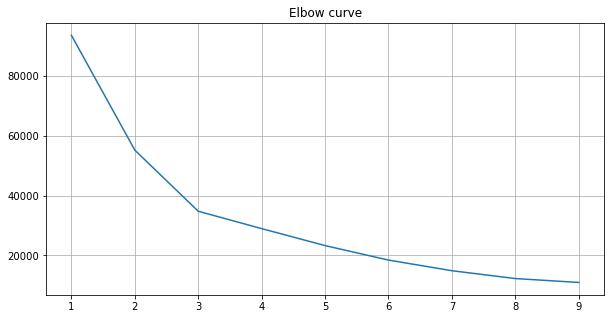

In [28]:
fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [24]:
Ks = range(1, 10)
km = [KMeans(n_clusters=i) for i in Ks]
score = [km[i].fit(X).score(X) for i in range(len(km))]

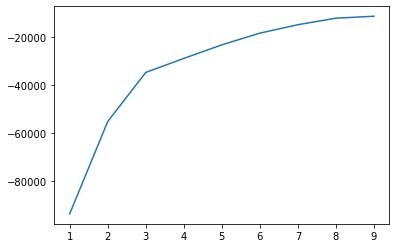

In [23]:
plt.plot(Ks, score)

--> Based on Silhoutte Scores and Elbow Method, we select k=3 (# of clusters)

## Clustering

In [43]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
kmeans.fit(X)
print(kmeans.labels_)

[2 0 0 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 0 0 0 2 2 2 1 1 2 2 2 0 0 2 2 0 0
 0 0 0 2 0 0 0 0 0 0 2 0 2 0 0 0 0 2]


C:\Users\m_carper\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\m_carper\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [78]:
df_inputs['labels'] = kmeans.labels_
cluster_sum = df_inputs.groupby(by='labels').mean()
cluster_sum.head()

,park_perc,job_perc_norm,home_own,comp_access,broadb_access,bach_degr,empl_rate,rent_under30,rent_under50
labels,,,,,,,,,
0,65.682609,4.139130,48.091304,77.713043,71.117391,33.091304,94.078261,45.869565,69.491304
1,95.987500,60.937500,30.050000,87.550000,80.600000,72.487500,95.650000,58.662500,80.587500
2,91.450000,9.920833,18.070833,68.725000,65.425000,28.804167,91.741667,43.387500,69.262500


In [79]:
cluster_sum2 = df_inputs.groupby(by='labels').median()
cluster_sum2.head()

,park_perc,job_perc_norm,home_own,comp_access,broadb_access,bach_degr,empl_rate,rent_under30,rent_under50
labels,,,,,,,,,
0,66.00,3.60,46.00,79.00,73.70,30.90,94.10,47.00,70.6
1,95.90,58.25,32.65,88.95,83.90,75.80,95.75,60.10,81.2
2,92.75,7.95,16.85,71.65,64.75,30.65,92.00,44.05,69.5


In [80]:
df_inputs['labels'].value_counts()

2    24
0    23
1     8
Name: labels, dtype: int64

In [81]:
i=0
vals_list = [23,8,24]
while i < 3:
    print("Cluster",i,"-",str(int(vals_list[i]*100/sum(vals_list)))+"% of total")
    i+=1

Cluster 0 - 41% of total
Cluster 1 - 14% of total
Cluster 2 - 43% of total


In [82]:
df_inputs

,PUMA,park_perc,job_perc_norm,home_own,comp_access,broadb_access,bach_degr,empl_rate,rent_under30,rent_under50,labels
0,3603701,91.5,4.7,31.1,75.5,73.2,40.6,93.0,46.1,70.7,2
1,3603702,63.4,2.2,38.1,68.2,59.8,24.4,90.6,39.3,65.5,0
2,3603703,49.9,1.6,47.1,73.9,66.2,26.3,92.4,50.3,70.6,0
3,3603704,84.5,4.6,29.7,71.6,60.9,24.5,91.5,41.8,69.7,2
4,3603705,99.2,6.1,6.5,54.6,58.0,12.8,87.4,36.1,61.3,2
5,3603706,97.5,5.9,6.2,61.0,60.7,15.4,88.7,35.3,63.4,2
6,3603707,100.0,6.6,3.8,56.8,57.8,13.0,87.4,34.9,59.9,2
7,3603708,99.7,8.0,6.2,59.7,58.8,15.4,89.8,37.4,61.7,2
8,3603709,86.3,2.8,20.9,65.9,64.1,17.4,90.8,40.3,67.7,2
9,3603710,95.2,8.9,7.9,54.9,56.4,12.3,87.7,38.6,65.4,2


## Results

### Geography of Clusters

In [72]:
df_inputs['puma'] = df_inputs['PUMA'].str[3:]
cluster_shapefile = pd.merge(puma_shape, df_inputs, how='left', on='puma')

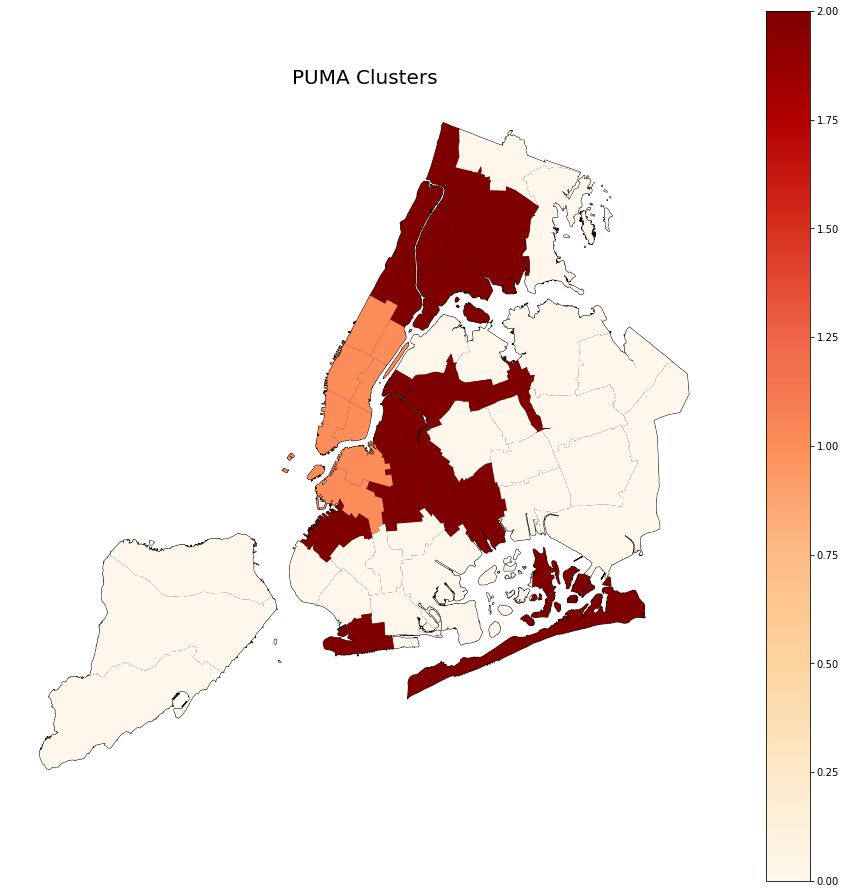

In [69]:
base = cluster_shapefile.plot(color='white', edgecolor='black', figsize=(16,16))
ax = cluster_shapefile.plot(column='labels',cmap='OrRd',ax=base)
ax.set_aspect='equal'
ax.axis('off')
sm.set_array([0,1,2])
plt.colorbar(sm)
plt.title('PUMA Clusters',size=20)
plt.show()

In [83]:
cluster_sum2 = df_inputs.groupby(by='labels').median()
cluster_sum2.head()

,park_perc,job_perc_norm,home_own,comp_access,broadb_access,bach_degr,empl_rate,rent_under30,rent_under50
labels,,,,,,,,,
0,66.00,3.60,46.00,79.00,73.70,30.90,94.10,47.00,70.6
1,95.90,58.25,32.65,88.95,83.90,75.80,95.75,60.10,81.2
2,92.75,7.95,16.85,71.65,64.75,30.65,92.00,44.05,69.5


### Correlation Matrix for Input Variables

<AxesSubplot:>

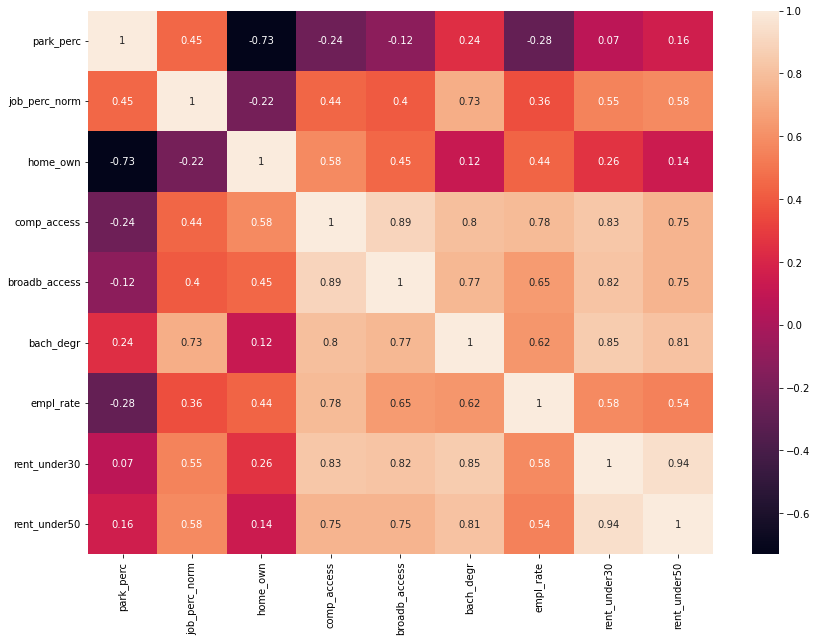

In [84]:
plt.subplots(figsize=(14,10))
sns.heatmap(X.corr(), annot = True)